# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/isabella/Documents/KTH/ScalableML/mlfs-book_scalabel_ml
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 23, 42, 17, 675132)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 23:42:17,681 INFO: Initializing external client
2025-11-18 23:42:17,681 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 23:42:18,775 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 23:42:19,954 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279144


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

# Get all versions of the model and select the latest one
model_versions = mr.get_models(name="air_quality_xgboost_model")
if not model_versions:
    raise ValueError("No models found with name 'air_quality_xgboost_model'. Please train the model first.")

# Sort by version and get the latest
latest_version = max([m.version for m in model_versions])
print(f"📦 Using model version: {latest_version}")

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=latest_version,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

📦 Using model version: 1
2025-11-18 23:42:26,226 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/534642 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105989 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/22553 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# DEBUG: Print the features the model expects
print("🔍 Model feature names:")
print(f"   {retrieved_xgboost_model.get_booster().feature_names}")
print(f"\n🔍 Number of features: {len(retrieved_xgboost_model.get_booster().feature_names)}")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

🔍 Model feature names:
   ['pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']

🔍 Number of features: 7


XGBRegressor(base_score='2.5142857E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-20 00:00:00+00:00,-0.85,0.1,13.004921,4.763556,Stockholm
1,2025-11-21 00:00:00+00:00,-1.85,0.0,18.278645,327.875031,Stockholm
2,2025-11-22 00:00:00+00:00,1.40,0.0,16.548256,225.881302,Stockholm
3,2025-11-23 00:00:00+00:00,1.40,0.0,9.387651,212.471176,Stockholm
4,2025-11-24 00:00:00+00:00,1.15,0.0,8.854829,296.564972,Stockholm
5,2025-11-22 00:00:00+00:00,1.30,0.0,16.548256,225.881302,stockholm
6,2025-11-21 00:00:00+00:00,-1.95,0.0,18.278645,327.875031,stockholm
7,2025-11-24 00:00:00+00:00,1.05,0.0,8.854829,296.564972,stockholm
8,2025-11-23 00:00:00+00:00,1.30,0.0,9.387651,212.471176,stockholm
9,2025-11-20 00:00:00+00:00,-0.95,0.1,13.004921,4.763556,stockholm


## <span style="color:#ff5f27;">🔄 Get Lagged PM2.5 Features</span>

To make accurate predictions with our model (which includes lagged features), we need to fetch the most recent 3 days of PM2.5 measurements.

In [8]:
# Get the air quality feature group to fetch recent PM2.5 values for lagged features
air_quality_fg_inference = fs.get_feature_group(name='air_quality', version=2)

# Get the most recent 3 days of PM2.5 data for lagged features
from datetime import timedelta

start_lag_date = today - timedelta(days=3)
end_lag_date = today - timedelta(days=1)

# Fetch recent PM2.5 values
recent_aq_query = air_quality_fg_inference.select(['date', 'pm25']) \
    .filter(air_quality_fg_inference.country == country) \
    .filter(air_quality_fg_inference.city == city) \
    .filter(air_quality_fg_inference.street == street) \
    .filter(air_quality_fg_inference.date >= start_lag_date) \
    .filter(air_quality_fg_inference.date <= end_lag_date)

try:
    recent_pm25_df = recent_aq_query.read()
    recent_pm25_df = recent_pm25_df.sort_values('date')
    
    if len(recent_pm25_df) >= 3:
        # Get the last 3 PM2.5 values for lagged features
        pm25_lags = recent_pm25_df['pm25'].tail(3).tolist()
        pm25_lag_1d = pm25_lags[-1]  # 1 day ago
        pm25_lag_2d = pm25_lags[-2]  # 2 days ago
        pm25_lag_3d = pm25_lags[-3]  # 3 days ago
        
        print(f"✅ Fetched lagged PM2.5 values:")
        print(f"   1 day ago: {pm25_lag_1d}")
        print(f"   2 days ago: {pm25_lag_2d}")
        print(f"   3 days ago: {pm25_lag_3d}")
    else:
        print(f"⚠️ Warning: Only found {len(recent_pm25_df)} days of data. Using zeros for missing lags.")
        pm25_lag_1d = 0
        pm25_lag_2d = 0
        pm25_lag_3d = 0
except Exception as e:
    print(f"⚠️ Error fetching lagged features: {e}")
    print("   Using zeros for lagged features.")
    pm25_lag_1d = 0
    pm25_lag_2d = 0
    pm25_lag_3d = 0

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 
⚠️ Warning: Only found 1 days of data. Using zeros for missing lags.


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

**Note on Multi-Day Forecasting with Lagged Features:**  
- **Day 1:** Uses real PM2.5 values from the previous 3 days (most accurate)
- **Day 2+:** Uses a mix of real and predicted PM2.5 values as lagged features (rolling forecast)  
- Prediction accuracy typically decreases for days further into the future

In [9]:
# Get the model's expected feature order
model_feature_names = retrieved_xgboost_model.get_booster().feature_names
print(f"📋 Model expects features in this order: {model_feature_names}\n")

# Add lagged features to batch data
# For the first forecast day, we use real lagged values
# For subsequent days, we use predictions as pseudo-lags (rolling forecast)
batch_data = batch_data.reset_index(drop=True)
predictions = []

for i in range(len(batch_data)):
    # Prepare features for this prediction IN THE CORRECT ORDER
    # Build dict first, then reorder to match model
    features_dict = {}
    
    # Add lagged features
    if i == 0:
        # First day: use real historical lags
        features_dict['pm25_lag_1d'] = pm25_lag_1d
        features_dict['pm25_lag_2d'] = pm25_lag_2d
        features_dict['pm25_lag_3d'] = pm25_lag_3d
    elif i == 1:
        # Second day: use 1 prediction, 2 real lags
        features_dict['pm25_lag_1d'] = predictions[0]
        features_dict['pm25_lag_2d'] = pm25_lag_1d
        features_dict['pm25_lag_3d'] = pm25_lag_2d
    elif i == 2:
        # Third day: use 2 predictions, 1 real lag
        features_dict['pm25_lag_1d'] = predictions[1]
        features_dict['pm25_lag_2d'] = predictions[0]
        features_dict['pm25_lag_3d'] = pm25_lag_1d
    else:
        # Fourth day onwards: all predictions
        features_dict['pm25_lag_1d'] = predictions[i-1]
        features_dict['pm25_lag_2d'] = predictions[i-2]
        features_dict['pm25_lag_3d'] = predictions[i-3]
    
    # Add weather features
    features_dict['temperature_2m_mean'] = batch_data.loc[i, 'temperature_2m_mean']
    features_dict['precipitation_sum'] = batch_data.loc[i, 'precipitation_sum']
    features_dict['wind_speed_10m_max'] = batch_data.loc[i, 'wind_speed_10m_max']
    features_dict['wind_direction_10m_dominant'] = batch_data.loc[i, 'wind_direction_10m_dominant']
    
    # Create DataFrame and reorder columns to match model's expected order
    feature_vector = pd.DataFrame([features_dict])
    feature_vector = feature_vector[model_feature_names]  # Reorder to match model
    
    # Make prediction
    pred = retrieved_xgboost_model.predict(feature_vector)[0]
    predictions.append(pred)

batch_data['predicted_pm25'] = predictions
print(f"\n✅ Made {len(predictions)} predictions using lagged features")
batch_data

📋 Model expects features in this order: ['pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']


✅ Made 10 predictions using lagged features


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-20 00:00:00+00:00,-0.85,0.1,13.004921,4.763556,Stockholm,19.029621
1,2025-11-21 00:00:00+00:00,-1.85,0.0,18.278645,327.875031,Stockholm,21.878977
2,2025-11-22 00:00:00+00:00,1.40,0.0,16.548256,225.881302,Stockholm,27.820093
3,2025-11-23 00:00:00+00:00,1.40,0.0,9.387651,212.471176,Stockholm,31.377659
4,2025-11-24 00:00:00+00:00,1.15,0.0,8.854829,296.564972,Stockholm,37.072075
5,2025-11-22 00:00:00+00:00,1.30,0.0,16.548256,225.881302,stockholm,30.867083
6,2025-11-21 00:00:00+00:00,-1.95,0.0,18.278645,327.875031,stockholm,20.976269
7,2025-11-24 00:00:00+00:00,1.05,0.0,8.854829,296.564972,stockholm,25.904215
8,2025-11-23 00:00:00+00:00,1.30,0.0,9.387651,212.471176,stockholm,32.795555
9,2025-11-20 00:00:00+00:00,-0.95,0.1,13.004921,4.763556,stockholm,27.769453


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         10 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          10 non-null     float32                
 2   precipitation_sum            10 non-null     float32                
 3   wind_speed_10m_max           10 non-null     float32                
 4   wind_direction_10m_dominant  10 non-null     float32                
 5   city                         10 non-null     object                 
 6   predicted_pm25               10 non-null     float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 488.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-20 00:00:00+00:00,-0.85,0.1,13.004921,4.763556,stockholm,19.029621,hornsgatan-108,sweden,1
9,2025-11-20 00:00:00+00:00,-0.95,0.1,13.004921,4.763556,stockholm,27.769453,hornsgatan-108,sweden,10
1,2025-11-21 00:00:00+00:00,-1.85,0.0,18.278645,327.875031,stockholm,21.878977,hornsgatan-108,sweden,2
6,2025-11-21 00:00:00+00:00,-1.95,0.0,18.278645,327.875031,stockholm,20.976269,hornsgatan-108,sweden,7
2,2025-11-22 00:00:00+00:00,1.40,0.0,16.548256,225.881302,stockholm,27.820093,hornsgatan-108,sweden,3
5,2025-11-22 00:00:00+00:00,1.30,0.0,16.548256,225.881302,stockholm,30.867083,hornsgatan-108,sweden,6
3,2025-11-23 00:00:00+00:00,1.40,0.0,9.387651,212.471176,stockholm,31.377659,hornsgatan-108,sweden,4
8,2025-11-23 00:00:00+00:00,1.30,0.0,9.387651,212.471176,stockholm,32.795555,hornsgatan-108,sweden,9
4,2025-11-24 00:00:00+00:00,1.15,0.0,8.854829,296.564972,stockholm,37.072075,hornsgatan-108,sweden,5
7,2025-11-24 00:00:00+00:00,1.05,0.0,8.854829,296.564972,stockholm,25.904215,hornsgatan-108,sweden,8


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         10 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          10 non-null     float32                
 2   precipitation_sum            10 non-null     float32                
 3   wind_speed_10m_max           10 non-null     float32                
 4   wind_direction_10m_dominant  10 non-null     float32                
 5   city                         10 non-null     object                 
 6   predicted_pm25               10 non-null     float32                
 7   street                       10 non-null     object                 
 8   country                      10 non-null     object                 
 9   days_before_forecast_day     10 non-null     int64                  
dtypes: datetim

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 23:42:38,066 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



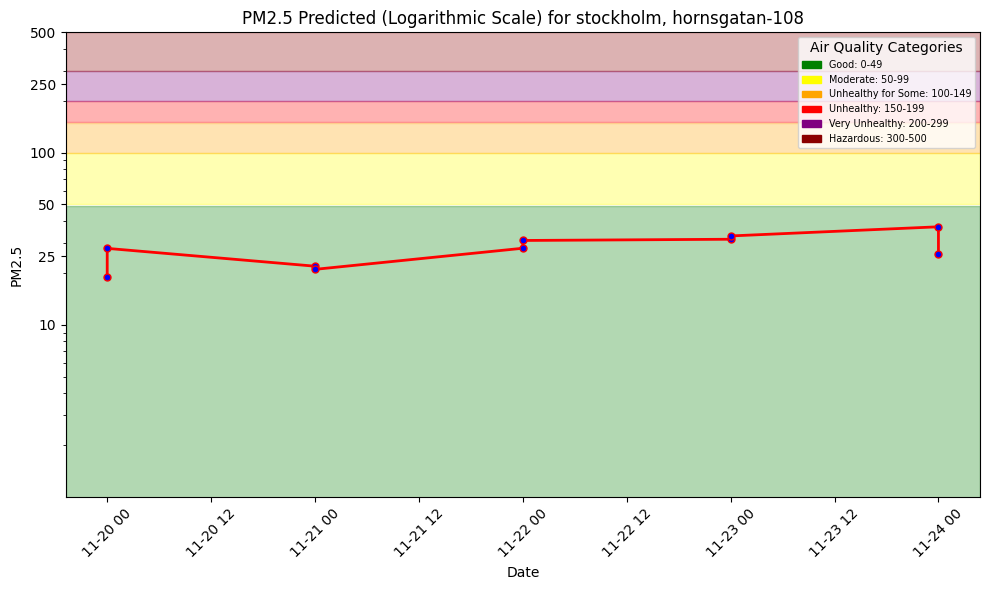

In [13]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [14]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [15]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279144/fs/1265752/fg/1719072


Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279144/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 23:42:57,973 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 23:43:01,153 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 23:44:40,660 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 23:44:40,825 INFO: Waiting for log aggregation to finish.
2025-11-18 23:45:02,778 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [16]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-20 00:00:00+00:00,-0.85,0.1,13.004921,4.763556,stockholm,19.029621,hornsgatan-108,sweden,1


In [17]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=2)  # Using version 2 with lagged features
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.18s) 


,date,pm25,country,city,street,url,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d
0,2018-12-27 00:00:00+00:00,17.0,Sweden,Stockholm,Hornsgatan-108,https://api.waqi.info/feed/@10220,11.0,18.0,24.0
1,2018-01-22 00:00:00+00:00,37.0,Sweden,Stockholm,Hornsgatan-108,https://api.waqi.info/feed/@10220,58.0,38.0,45.0
2,2025-05-23 00:00:00+00:00,11.0,Sweden,Stockholm,Hornsgatan-108,https://api.waqi.info/feed/@10220,14.0,12.0,18.0
3,2023-05-06 00:00:00+00:00,27.0,Sweden,Stockholm,Hornsgatan-108,https://api.waqi.info/feed/@10220,35.0,27.0,19.0
4,2025-05-02 00:00:00+00:00,19.0,Sweden,Stockholm,Hornsgatan-108,https://api.waqi.info/feed/@10220,18.0,18.0,12.0
...,...,...,...,...,...,...,...,...,...
5741,2018-05-27 00:00:00+00:00,33.0,sweden,stockholm,hornsgatan-108,https://api.waqi.info/feed/@10220/,36.0,25.0,26.0
5742,2018-05-26 00:00:00+00:00,36.0,sweden,stockholm,hornsgatan-108,https://api.waqi.info/feed/@10220/,25.0,26.0,40.0
5743,2024-02-11 00:00:00+00:00,34.0,sweden,stockholm,hornsgatan-108,https://api.waqi.info/feed/@10220/,23.0,22.0,55.0
5744,2019-09-16 00:00:00+00:00,6.0,sweden,stockholm,hornsgatan-108,https://api.waqi.info/feed/@10220/,9.0,8.0,12.0


In [18]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.53s) 


Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

ValueError: nan (type <class 'float'>) do not match ['null', 'string'] on field street

%6|1763505960.236|FAIL|rdkafka#producer-3| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50052ms in state UP)
%6|1763506011.405|FAIL|rdkafka#producer-3| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50119ms in state UP)
%6|1763506062.993|FAIL|rdkafka#producer-3| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50127ms in state UP)
%6|1763506113.788|FAIL|rdkafka#producer-3| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50111ms in state UP, 1 identical error(s) suppressed)
%6|1763506227.066|FAIL|rdkafka#producer-3| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 112159ms in state UP, 1 identical error(s) suppressed)
%6|1763507247.291|FAIL|rdkafka#producer-3| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 1019724ms in state UP, 1

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

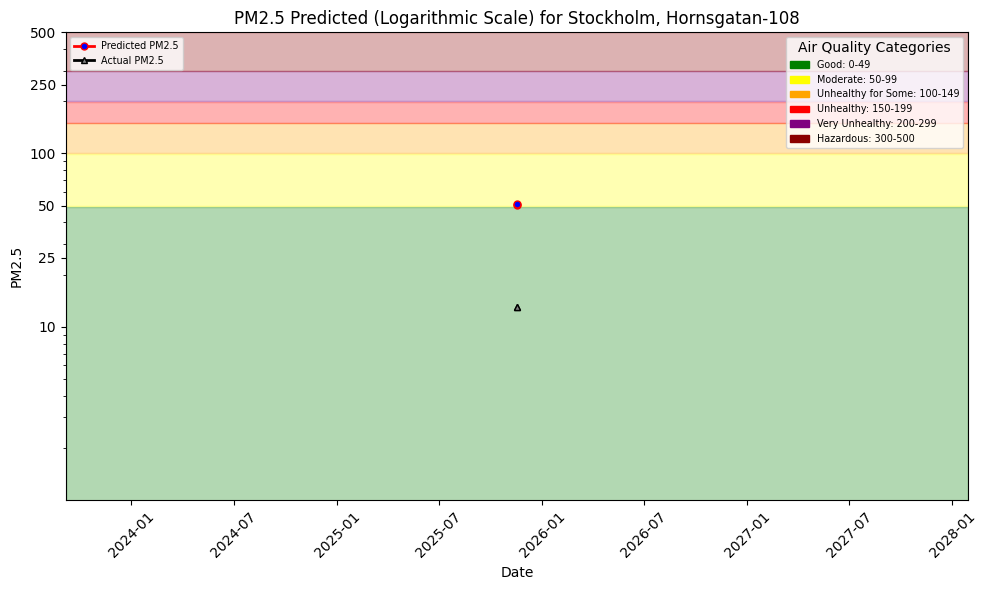

In [ ]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/simon/PycharmProjects/mlfs-book_scalabel_ml/docs/air-quality/assets/img/pm25_forecast.png: 0.0…

Uploading /home/simon/PycharmProjects/mlfs-book_scalabel_ml/docs/air-quality/assets/img/pm25_hindcast_1day.png…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279143/settings/fb/path/Resources/airquality


---